Let's walk through a basic visualization of an undirected graph using NetworkX and the Spotify API

In [1]:
import os
import spotipy as sp
import matplotlib.pyplot as plt
import networkx as nx
from dotenv import load_dotenv
%matplotlib inline

In [2]:
# Load environment variables to create a credentialed Spotify instance
load_dotenv()
auth_manager = sp.oauth2.SpotifyClientCredentials()
spotify = sp.Spotify(auth_manager=auth_manager)

In [3]:
seed_artist = spotify.artist("6nS5roXSAGhTGr34W6n7Et") # Disclosure, a favorite artist of mine.
print(seed_artist)

{'external_urls': {'spotify': 'https://open.spotify.com/artist/6nS5roXSAGhTGr34W6n7Et'}, 'followers': {'href': None, 'total': 1988464}, 'genres': ['house', 'pop', 'tropical house', 'uk dance'], 'href': 'https://api.spotify.com/v1/artists/6nS5roXSAGhTGr34W6n7Et', 'id': '6nS5roXSAGhTGr34W6n7Et', 'images': [{'height': 640, 'url': 'https://i.scdn.co/image/ab6761610000e5eb784a17787904570df53ae9a2', 'width': 640}, {'height': 320, 'url': 'https://i.scdn.co/image/ab67616100005174784a17787904570df53ae9a2', 'width': 320}, {'height': 160, 'url': 'https://i.scdn.co/image/ab6761610000f178784a17787904570df53ae9a2', 'width': 160}], 'name': 'Disclosure', 'popularity': 77, 'type': 'artist', 'uri': 'spotify:artist:6nS5roXSAGhTGr34W6n7Et'}


We take our seed artist and build a dictionary representation of a graph using a recursive function pattern. Spotipy will return a lot of related artists on each call, so we limit the amount we get back on each call with a `max_children` parameter

In [4]:
def convert_artist_to_node(artist):
    """Extract a tuple consisting of the artist's ID and Name"""
    return (artist['id'], artist['name'])


def build_related_artists(seed_artist, max_children, level):
    """Build a dictionary representation of a graph.
    
    We use a recursive pattern to build our result.
    Each key in our dictionary is a tuple node extracted from the artist response.
    Nested invocations receive the data structure along with a decremented depth counter and a max_children parameter.
    """
    seed_node = convert_artist_to_node(seed_artist)
    result = {}
    
    def helper(node, depth, d):
        if depth > 0:
            related_artists = spotify.artist_related_artists(node[0])
            for ra in related_artists['artists'][:max_children]:
                ra_node = convert_artist_to_node(ra)
                if node in d:
                    # The parent node already exists and has children.
                    # Add the related artist node to its set of children
                    d[node].add(ra_node)
                else:
                    # Current parent node doesn't have any existing children, initialize the related artist to it
                    d[node] = {ra_node}
                d = helper(ra_node, depth - 1, d)
        return d
    return helper(seed_node, level, result)

In [11]:
gdict = build_related_artists(seed_artist, max_children=4, level=3)

Before we output the graph, let's map the correct labels for each node so our display shows the artist name and not a mess of tuples.

In [12]:
labels = {}
for k, s in gdict.items():
    labels[k] = k[1]
    for t in s:
        labels[t] = t[1]

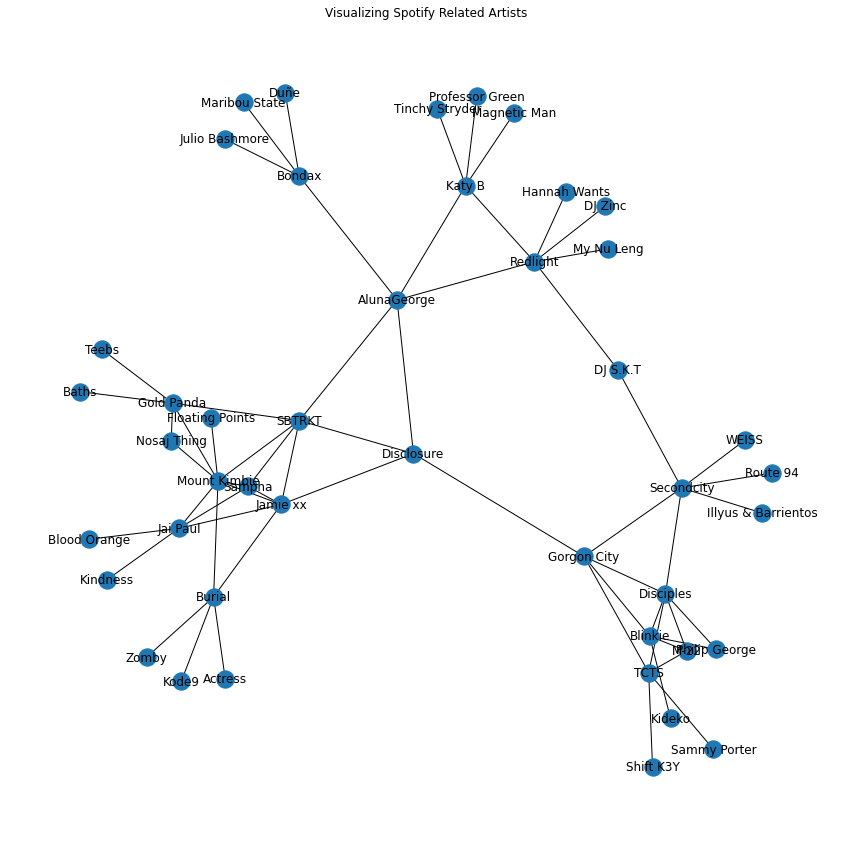

In [13]:
G = nx.Graph(gdict)
fig, ax = plt.subplots(figsize=(15,15))
nx.draw(G, with_labels=True, ax=ax, labels=labels)
plt.title('Visualizing Spotify Related Artists')
plt.draw()
plt.show()